[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar-ramos/robotica-autonoma-python/blob/main/3-Intro-Vision/3-02-Procesamiento-Basico.ipynb)

## 1. Lectura y visualización de imágenes (modular)

Este apartado define funciones para cargar y mostrar imágenes de forma reutilizable.

In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Carga una imagen desde disco (formato BGR) y la devuelve en RGB.
def cargar_imagen(ruta: str):
   
    img_bgr = cv2.imread(ruta)
    if img_bgr is None:
        raise FileNotFoundError(f"No se encontró la imagen en {ruta}")
    # Convertir de BGR a RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb

In [9]:
#Muestra una imagen RGB usando matplotlib.
def mostrar_imagen(img: "np.ndarray", título: str = "Imagen", tamaño: tuple = (8, 6)):

    plt.figure(figsize=tamaño)
    plt.imshow(img)
    plt.title(título)
    plt.axis('off')
    plt.show()


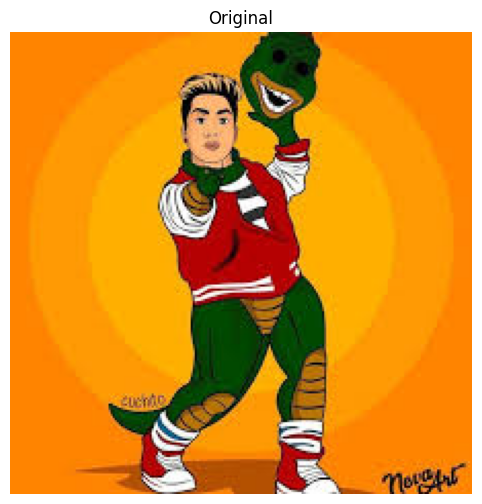

Dimensiones de la imagen: (225, 225, 3)


In [10]:
# — Ejecución de ejemplo —
img = cargar_imagen('images/sideral.png')
mostrar_imagen(img, 'Original')
print(f"Dimensiones de la imagen: {img.shape}")

## 2. Cálculo y visualización de histogramas (modular)

En esta sección crearemos una función que calcule y muestre el histograma de una o varias componentes de la imagen.

In [14]:
# Calcula el histograma de un canal de la imagen.
def calcular_histograma(img: np.ndarray, canal: int = 0, bins: int = 256) -> (np.ndarray, np.ndarray):

    canal_data = img[:, :, canal].ravel()
    hist, bin_edges = np.histogram(canal_data, bins=bins, range=(0, 256))
    return hist, bin_edges

In [ ]:
def mostrar_histograma(img: np.ndarray,
                       canales: list = [0, 1, 2],
                       labels: list = ['Rojo','Verde','Azul'],
                       bins: int = 256,
                       título: str = 'Histograma de Intensidades',
                       tamaño: tuple = (8, 5)):
    
    plt.figure(figsize=tamaño)
    for canal, label in zip(canales, labels):
        hist, edges = calcular_histograma(img, canal, bins)
        plt.plot(edges[:-1], hist, label=label)
    plt.title(título)
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True)
    plt.show()

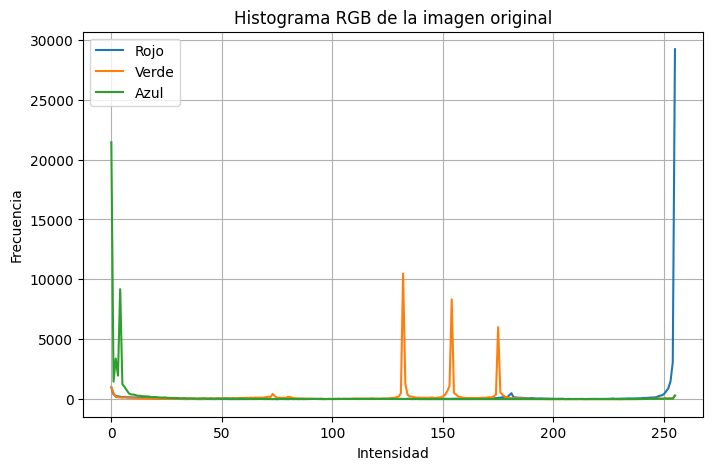

In [16]:
mostrar_histograma(img, título='Histograma RGB de la imagen original')

## 3. Comparación de histogramas antes/después de un filtro

En esta sección aplicamos un filtro de suavizado y comparamos los histogramas de la imagen original y la filtrada.

In [17]:
def suavizar_gauss(img: np.ndarray, kernel_size: tuple = (5, 5), sigma: float = 0) -> np.ndarray:

    # OpenCV espera BGR, así que convertimos y luego revertimos:
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    suav_bgr = cv2.GaussianBlur(img_bgr, kernel_size, sigmaX=sigma)
    return cv2.cvtColor(suav_bgr, cv2.COLOR_BGR2RGB)


In [18]:
def comparar_histogramas(img1: np.ndarray,
                         img2: np.ndarray,
                         título1: str = "Original",
                         título2: str = "Filtrada",
                         canales: list = [0,1,2],
                         labels: list = ['R','G','B']):

    # Mostrar imágenes
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes[0,0].imshow(img1); axes[0,0].set_title(título1); axes[0,0].axis('off')
    axes[0,1].imshow(img2); axes[0,1].set_title(título2); axes[0,1].axis('off')

    # Mostrar histogramas
    for canal, label in zip(canales, labels):
        h1, e1 = np.histogram(img1[:,:,canal].ravel(), bins=256, range=(0,256))
        h2, e2 = np.histogram(img2[:,:,canal].ravel(), bins=256, range=(0,256))
        axes[1,0].plot(e1[:-1], h1, label=label)
        axes[1,1].plot(e2[:-1], h2, label=label)

    axes[1,0].set_title(f'Histograma: {título1}')
    axes[1,1].set_title(f'Histograma: {título2}')
    for ax in axes[1]:
        ax.set_xlabel('Intensidad')
        ax.set_ylabel('Frecuencia')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

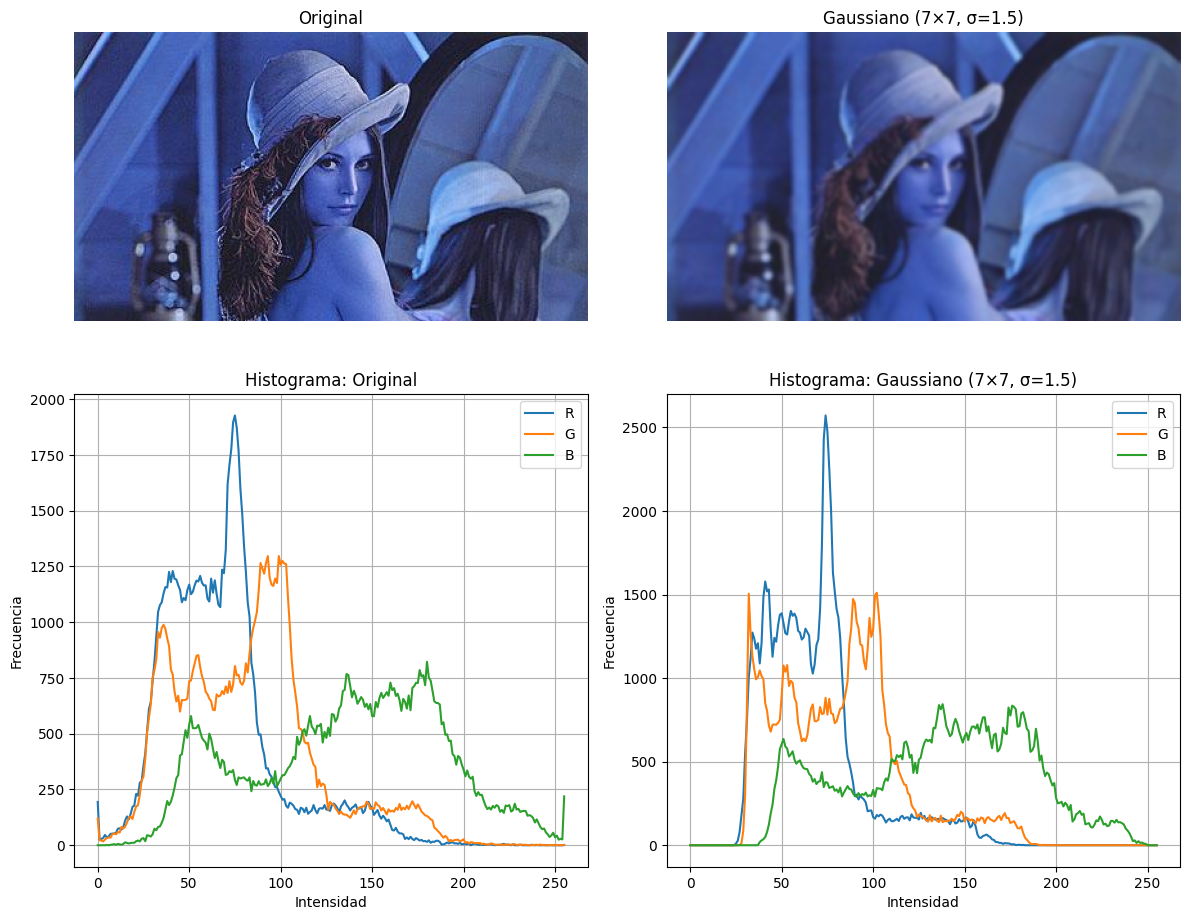

In [ ]:
img = cargar_imagen('images/RBG.jpg')
img_suav = suavizar_gauss(img, kernel_size=(7,7), sigma=1.5)
comparar_histogramas(img, img_suav, título2='Gaussiano (7×7, σ=1.5)')

## 4. Umbralización

In [21]:
def convertir_a_gris(img_rgb: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

In [22]:
def umbral_fijo(img_gray: np.ndarray,
                thresh: int = 127,
                max_val: int = 255) -> np.ndarray:
    _, binarizada = cv2.threshold(img_gray, thresh, max_val, cv2.THRESH_BINARY)
    return binarizada

In [ ]:
#Aplica umbralización automática de Otsu.
def umbral_otsu(img_gray: np.ndarray,max_val: int = 255) -> (np.ndarray, int):
    
    thresh_otsu, binarizada = cv2.threshold(
        img_gray, 0, max_val,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    return binarizada, int(thresh_otsu)

In [24]:
#Muestra la imagen original, escala de grises, binarización fija y Otsu.
def mostrar_umbralizaciones(img_rgb: np.ndarray,
                            thresh_fijo: int = 127):

    img_gray = convertir_a_gris(img_rgb)
    bin_fijo = umbral_fijo(img_gray, thresh_fijo)
    bin_otsu, t_otsu = umbral_otsu(img_gray)

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    # Original
    axes[0,0].imshow(img_rgb)
    axes[0,0].set_title("Original RGB")
    axes[0,0].axis('off')
    # Gris
    axes[0,1].imshow(img_gray, cmap='gray')
    axes[0,1].set_title("Escala de grises")
    axes[0,1].axis('off')
    # Umbral fijo
    axes[1,0].imshow(bin_fijo, cmap='gray')
    axes[1,0].set_title(f"Umbral fijo: {thresh_fijo}")
    axes[1,0].axis('off')
    # Otsu
    axes[1,1].imshow(bin_otsu, cmap='gray')
    axes[1,1].set_title(f"Otsu: {t_otsu}")
    axes[1,1].axis('off')

    plt.tight_layout()
    plt.show()


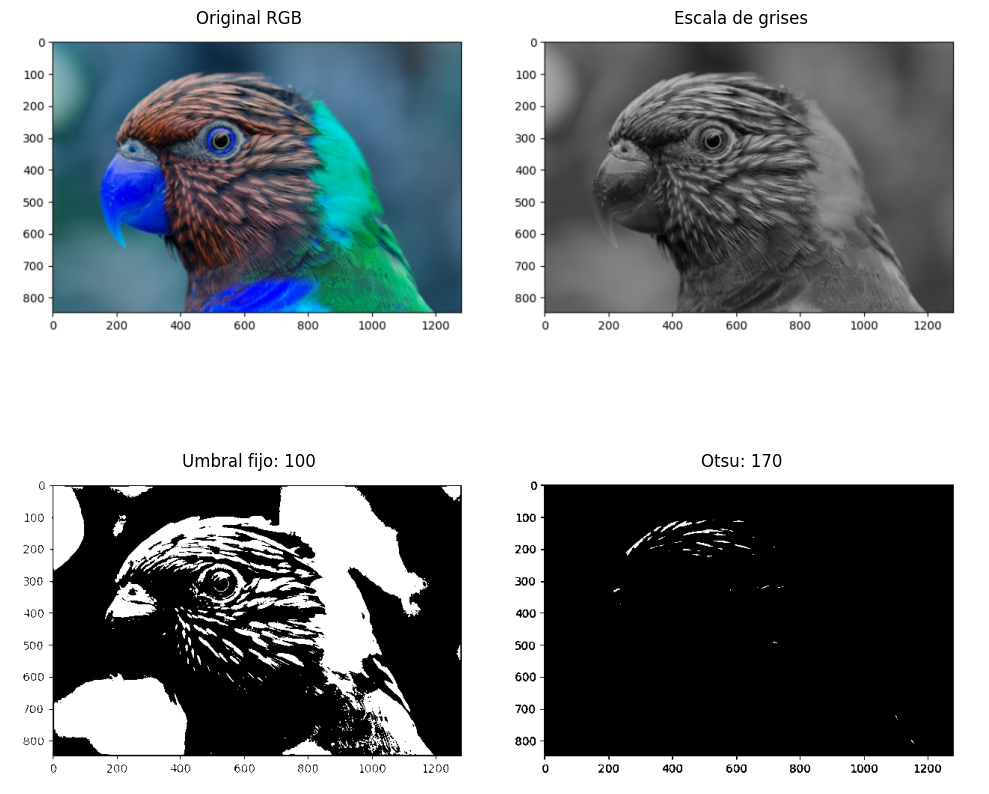

In [25]:
img = cargar_imagen('images/LORO.png')
mostrar_umbralizaciones(img, thresh_fijo=100)

## 5. Morfología Matemática

En esta sección definiremos funciones para aplicar operaciones morfológicas básicas (erosión, dilatación, apertura, cierre) y algunos operadores compuestos, sobre la imagen binarizada.

In [26]:
#Crea un kernel estructurante.
def crear_kernel(shape: str = 'rect', ksize: tuple = (5,5)) -> np.ndarray:
    if shape == 'rect':
        return cv2.getStructuringElement(cv2.MORPH_RECT, ksize)
    elif shape == 'ellipse':
        return cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    elif shape == 'cross':
        return cv2.getStructuringElement(cv2.MORPH_CROSS, ksize)
    else:
        raise ValueError(f"shape debe ser 'rect', 'ellipse' o 'cross', no '{shape}'")


In [27]:
#Aplica erosión morfológica
def erosion(img_bin: np.ndarray, kernel: np.ndarray, iterations: int = 1) -> np.ndarray:
    return cv2.erode(img_bin, kernel, iterations=iterations)

#Aplica dilatación morfológica.
def dilatacion(img_bin: np.ndarray, kernel: np.ndarray, iterations: int = 1) -> np.ndarray:
    return cv2.dilate(img_bin, kernel, iterations=iterations)

#Aplica apertura (erosión seguida de dilatación).
def apertura(img_bin: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    return cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel)

#Aplica cierre (dilatación seguida de erosión).
def cierre(img_bin: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    
    return cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, kernel)

#Calcula el gradiente morfológico (dilatación − erosión).
def gradiente_morfologico(img_bin: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    return cv2.morphologyEx(img_bin, cv2.MORPH_GRADIENT, kernel)

#Top-hat: diferencia entre la imagen y su apertura.
def top_hat(img_bin: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    
    return cv2.morphologyEx(img_bin, cv2.MORPH_TOPHAT, kernel)

#Black-hat: diferencia entre cierre y la imagen.
def black_hat(img_bin: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    return cv2.morphologyEx(img_bin, cv2.MORPH_BLACKHAT, kernel)


In [28]:
#Muestra la imagen binaria original y varias operaciones morfológicas.
def mostrar_morfologia(img_bin: np.ndarray, kernel: np.ndarray):

    ops = {
        'Original': img_bin,
        'Erosión': erosion(img_bin, kernel),
        'Dilatación': dilatacion(img_bin, kernel),
        'Apertura': apertura(img_bin, kernel),
        'Cierre': cierre(img_bin, kernel),
        'Gradiente': gradiente_morfologico(img_bin, kernel),
        'Top-Hat': top_hat(img_bin, kernel),
        'Black-Hat': black_hat(img_bin, kernel)
    }
    plt.figure(figsize=(12, 10))
    for i, (name, im) in enumerate(ops.items(), 1):
        ax = plt.subplot(3, 3, i)
        ax.imshow(im, cmap='gray')
        ax.set_title(name)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

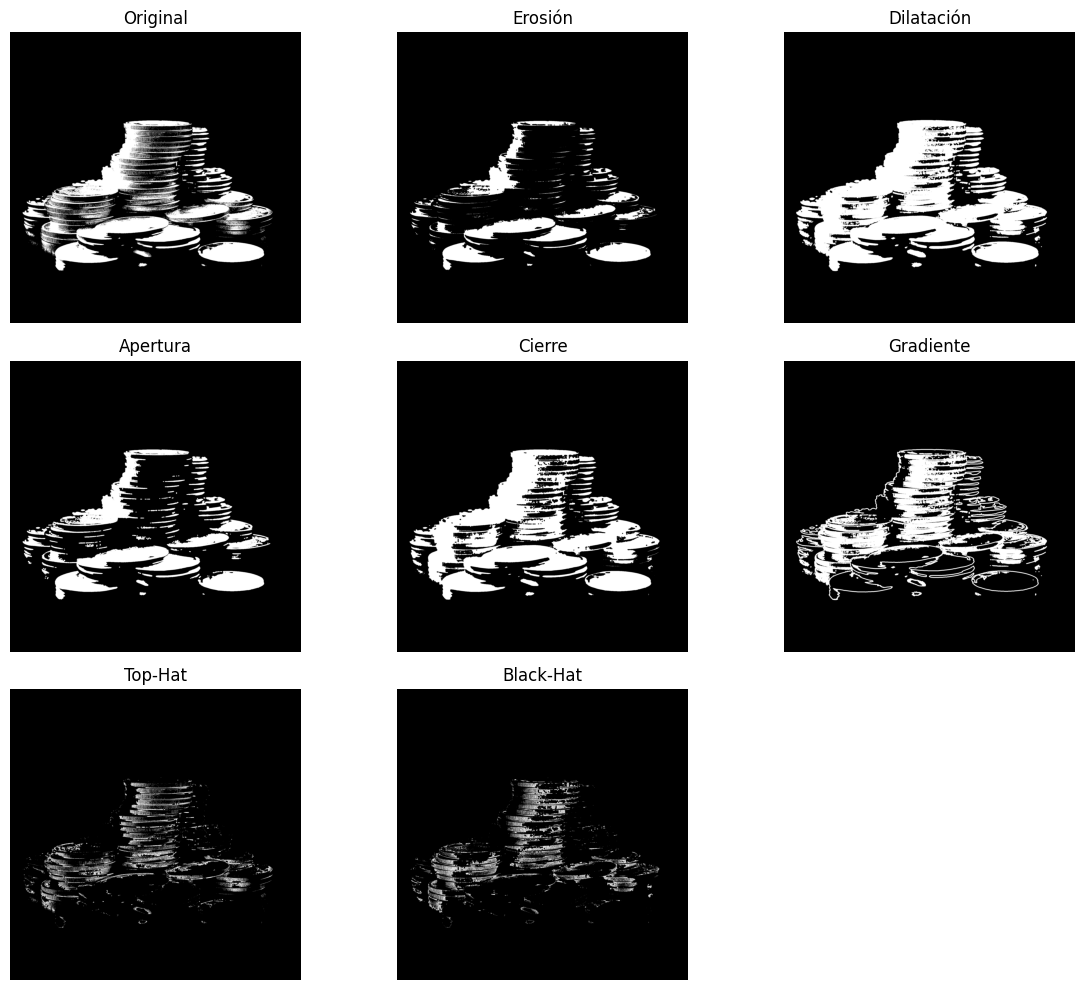

In [29]:
# — Ejecución de ejemplo —
img = cargar_imagen('images/monedas.png')
_, img_bin = cv2.threshold(convertir_a_gris(img), 0, 255,
                           cv2.THRESH_BINARY + cv2.THRESH_OTSU)
kern = crear_kernel('ellipse', (7,7))
mostrar_morfologia(img_bin, kern)

## 6. Transformaciones espaciales

En esta sección definiremos funciones para aplicar las transformaciones geométricas más comunes: traslación, escalado, rotación y transformación de perspectiva.

In [30]:
#Traslada la imagen tx píxeles en X y ty píxeles en Y.
def trasladar(img: np.ndarray, tx: float, ty: float) -> np.ndarray:
    h, w = img.shape[:2]
    M = np.array([[1, 0, tx],
                  [0, 1, ty]], dtype=np.float32)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    trasladada = cv2.warpAffine(img_bgr, M, (w, h))
    return cv2.cvtColor(trasladada, cv2.COLOR_BGR2RGB)

In [31]:
#Escala la imagen por factores sx y sy.
def escalar(img: np.ndarray, sx: float, sy: float) -> np.ndarray:
    h, w = img.shape[:2]
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    nueva_anchura = int(w * sx)
    nueva_altura  = int(h * sy)
    escalada = cv2.resize(img_bgr, (nueva_anchura, nueva_altura),
                          interpolation=cv2.INTER_LINEAR)
    return cv2.cvtColor(escalada, cv2.COLOR_BGR2RGB)

In [32]:
#Rota la imagen un ángulo dado alrededor de un centro.
def rotar(img: np.ndarray,
          angle: float,
          center: tuple = None,
          scale: float = 1.0) -> np.ndarray:
    h, w = img.shape[:2]
    if center is None:
        center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    rotada = cv2.warpAffine(img_bgr, M, (w, h))
    return cv2.cvtColor(rotada, cv2.COLOR_BGR2RGB)

In [41]:
#Aplica una transformación de perspectiva definida por 4 puntos origen y 4 destino.
def perspectiva(img: np.ndarray,
                src_pts: np.ndarray,
                dst_pts: np.ndarray) -> np.ndarray:
    h, w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src_pts.astype(np.float32),
                                    dst_pts.astype(np.float32))
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    per = cv2.warpPerspective(img_bgr, M, (w, h))
    return cv2.cvtColor(per, cv2.COLOR_BGR2RGB)

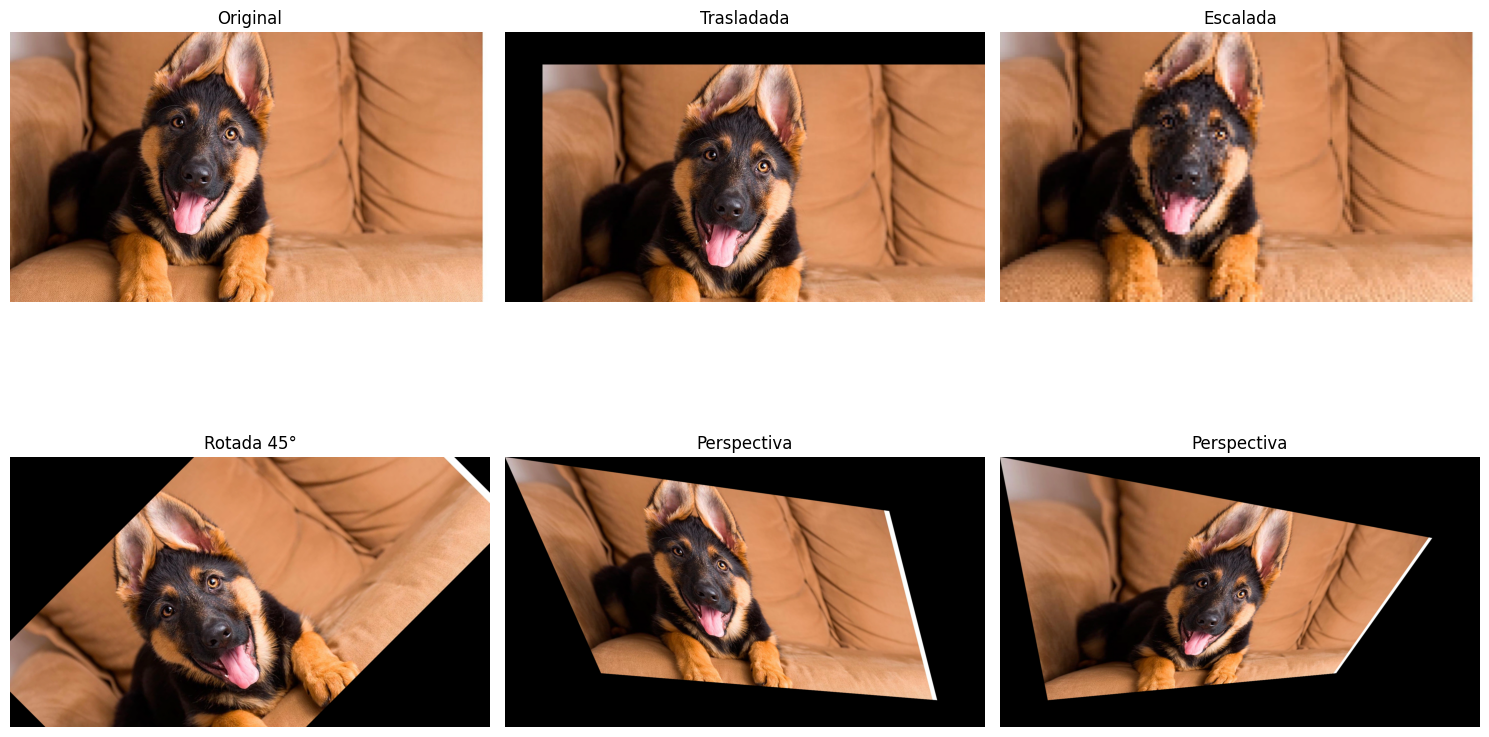

In [43]:
# — Ejecución de ejemplo —
img = cargar_imagen('images/perro.png')

# 1. Traslación
img_t = trasladar(img, tx=150, ty=130)

# 2. Escalado
img_s = escalar(img, sx=0.1, sy=0.1)

# 3. Rotación
img_r = rotar(img, angle=45)

# 4. Perspectiva (puntos de ejemplo)
h, w = img.shape[:2]
src = np.array([[0,0], [w-1,0], [w-1,h-1], [0,h-1]])
dst = np.array([[0,0], [w*0.8, h*0.2], [w*0.9, h*0.9], [w*0.2, h*0.8]])
img_p = perspectiva(img, src, dst)

h_1, w_2 = img.shape[:2]
src_1 = np.array([[0,0], [w-1,0], [w-2,h-2], [1,h-1]])
dst_1 = np.array([[0,0], [w*0.9, h*0.3], [w*0.7, h*0.8], [w*0.1, h*0.9]])
img_p_1 = perspectiva(img, src_1, dst_1)

# — Mostrar todos juntos —
fig, axs = plt.subplots(2, 3, figsize=(15,10))
axs[0,0].imshow(img);     axs[0,0].set_title('Original');      axs[0,0].axis('off')
axs[0,1].imshow(img_t);   axs[0,1].set_title('Trasladada');    axs[0,1].axis('off')
axs[0,2].imshow(img_s);   axs[0,2].set_title('Escalada');      axs[0,2].axis('off')
axs[1,0].imshow(img_r);   axs[1,0].set_title('Rotada 45°');     axs[1,0].axis('off')
axs[1,1].imshow(img_p);   axs[1,1].set_title('Perspectiva');   axs[1,1].axis('off')
axs[1,2].imshow(img_p_1);   axs[1,2].set_title('Perspectiva');   axs[1,2].axis('off')

plt.tight_layout()
plt.show()

## 7. Transformada de Fourier

In [44]:
#Calcula la DFT de la imagen y devuelve el espectro centrado y su magnitud en escala logarítmica.
def calcular_fft(img_gray: np.ndarray) -> (np.ndarray, np.ndarray):
    # DFT y desplazamiento al centro
    f = np.fft.fft2(img_gray)
    fshift = np.fft.fftshift(f)
    # Magnitud logarítmica
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    return fshift, magnitude_spectrum

In [45]:
#Crea y aplica un filtro pasa bajos circular.
def aplicar_filtro_pasa_bajos(fshift: np.ndarray, radio: int) -> np.ndarray:
    h, w = fshift.shape
    cy, cx = h // 2, w // 2
    mask = np.zeros_like(fshift, dtype=np.uint8)
    cv2.circle(mask, (cx, cy), radio, 1, thickness=-1)
    return fshift * mask

In [69]:
# Crea y aplica un filtro pasa altos circular (complemento del pasa bajos).
def aplicar_filtro_pasa_altos(fshift: np.ndarray, radio: int) -> np.ndarray:

    h, w = fshift.shape
    cy, cx = h // 2, w // 2
    mask = np.ones_like(fshift, dtype=np.uint8)
    cv2.circle(mask, (cx, cy), radio, 0, thickness=-1)
    return fshift * mask

In [47]:
#Reconstruye la imagen espacial desde la transformada centrada.
def reconstruir_imagen(fshift: np.ndarray) -> np.ndarray:
    # Desplazar de nuevo y aplicar IFT
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    # Normalización con numpy functions
    min_val = np.min(img_back)
    rango  = np.ptp(img_back)  # rango = max - min
    img_norm = (img_back - min_val) / rango
    img_uint8 = np.uint8(255 * img_norm)

    return img_uint8


In [48]:

#Muestra la imagen original, su espectro de magnitud, y los resultados de pasa bajos y pasa altos.
def mostrar_fft_y_filtros(img_gray: np.ndarray, radio: int = 30):

    # Cálculo de FFT
    fshift, mag = calcular_fft(img_gray)
    # Filtros
    f_lp = aplicar_filtro_pasa_bajos(fshift, radio)
    f_hp = aplicar_filtro_pasa_altos(fshift, radio)
    # Reconstrucción
    img_lp = reconstruir_imagen(f_lp)
    img_hp = reconstruir_imagen(f_hp)

    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes[0,0].imshow(img_gray, cmap='gray')
    axes[0,0].set_title('Original (Gris)')
    axes[0,0].axis('off')

    axes[0,1].imshow(mag, cmap='inferno')
    axes[0,1].set_title('Espectro de Magnitud (log)')
    axes[0,1].axis('off')

    axes[1,0].imshow(img_lp, cmap='gray')
    axes[1,0].set_title(f'Pasa Bajos (r={radio})')
    axes[1,0].axis('off')

    axes[1,1].imshow(img_hp, cmap='gray')
    axes[1,1].set_title(f'Pasa Altos (r={radio})')
    axes[1,1].axis('off')

    plt.tight_layout()
    plt.show()

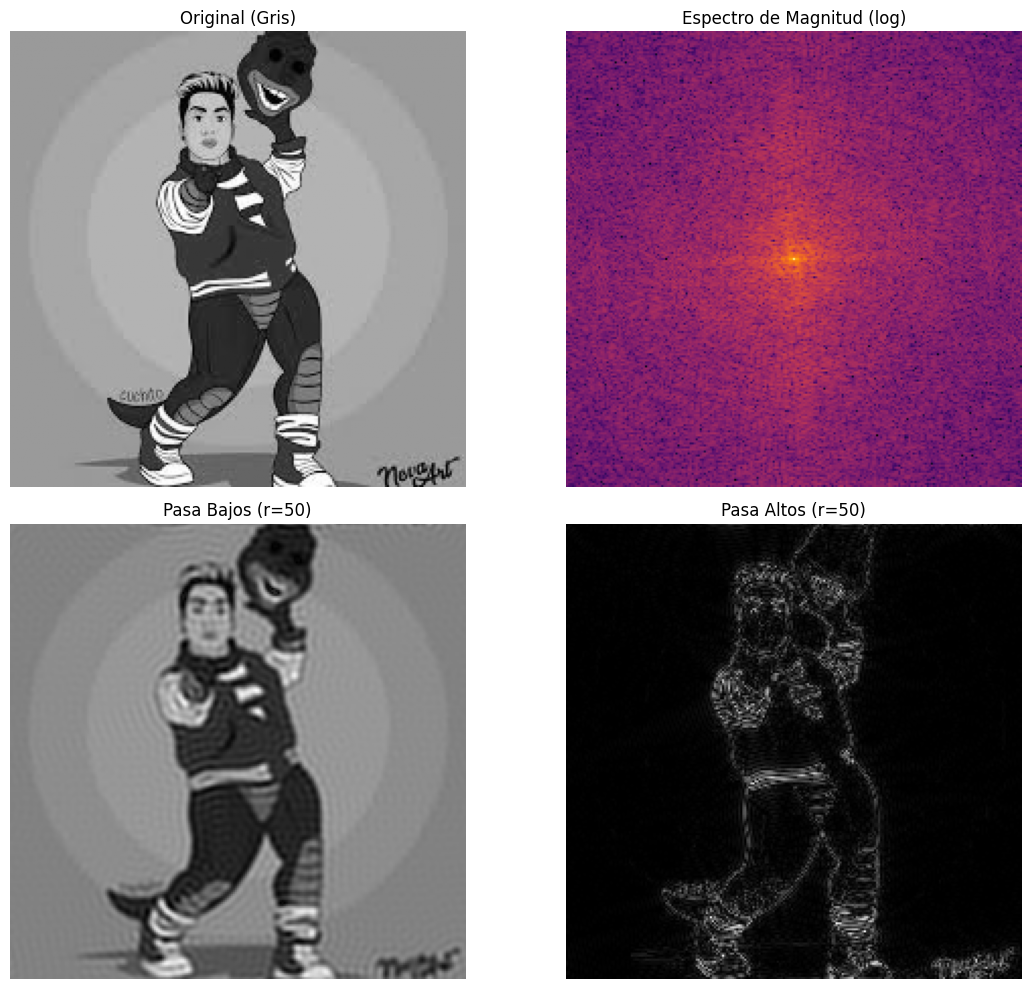

In [73]:
# — Ejecución de ejemplo —
img = cargar_imagen('images/sideral.png')
gris = convertir_a_gris(img)
mostrar_fft_y_filtros(gris, radio=50)

## 8. Color

In [ ]:
# Definir funciones
def cargar_imagen(ruta):
    return cv2.imread(ruta)

def mostrar_rgb(imagen):
    plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))

def convertir_a_hsv(imagen):
    return cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)

def mostrar_componente_h(hsv_img):
    plt.imshow(hsv_img[:, :, 0], cmap='gray')

def generar_mascara_color(hsv_img, lower, upper):
    return cv2.inRange(hsv_img, lower, upper)

def aplicar_mascara(imagen, mascara):
    return cv2.bitwise_and(imagen, imagen, mask=mascara)

def mostrar_mascara(mascara):
    plt.imshow(mascara, cmap='gray')

def mostrar_resultado_filtrado(imagen_filtrada):
    plt.imshow(cv2.cvtColor(imagen_filtrada, cv2.COLOR_BGR2RGB))


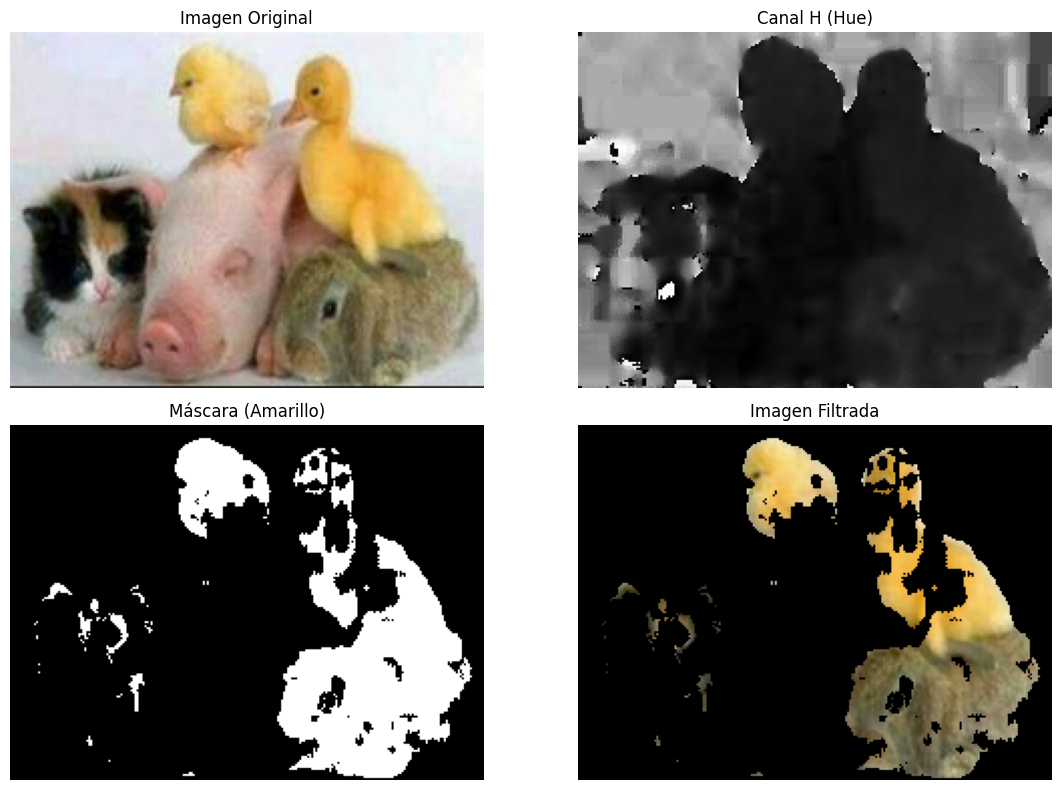

In [82]:
# Ruta de la imagen
ruta = "images/animales.png"  # Asegúrate de que esta ruta sea correcta
I = cargar_imagen(ruta)

# Validar si la imagen se cargó correctamente
if I is None:
    raise FileNotFoundError(f"No se encontró la imagen en la ruta: {ruta}")

# Conversión a HSV
Ihsv = convertir_a_hsv(I)

# Definir rango de amarillo
lower_yellow = np.array([20, 50, 50])
upper_yellow = np.array([40, 255, 255])
Imask = generar_mascara_color(Ihsv, lower_yellow, upper_yellow)

# Aplicar máscara
Ifiltcolor = aplicar_mascara(I, Imask)

# Mostrar todo en un grid 2x2
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Imagen original en RGB
ax[0, 0].imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
ax[0, 0].set_title("Imagen Original")
ax[0, 0].axis('off')

# Canal H (Hue)
ax[0, 1].imshow(Ihsv[:, :, 0], cmap='gray')
ax[0, 1].set_title("Canal H (Hue)")
ax[0, 1].axis('off')

# Máscara de color
ax[1, 0].imshow(Imask, cmap='gray')
ax[1, 0].set_title("Máscara (Amarillo)")
ax[1, 0].axis('off')

# Imagen filtrada con la máscara
ax[1, 1].imshow(cv2.cvtColor(Ifiltcolor, cv2.COLOR_BGR2RGB))
ax[1, 1].set_title("Imagen Filtrada")
ax[1, 1].axis('off')

plt.tight_layout()
plt.show()



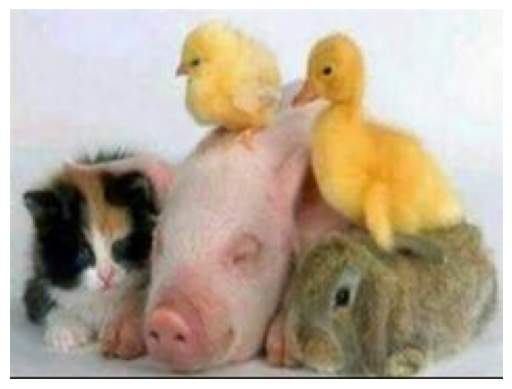

In [ ]:
# Leer la imagen
I = cv2.imread("images/animales.png")

plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
plt.axis('off'); plt.show()

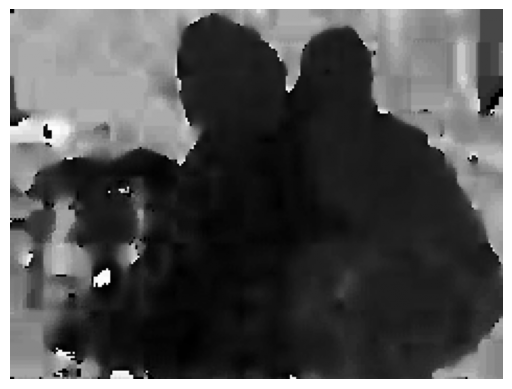

In [ ]:
# Convertir BGR a HSV
Ihsv = cv2.cvtColor(I, cv2.COLOR_BGR2HSV)

# Mostrar el componente H de HSV
plt.imshow(Ihsv[:,:,0], cmap='gray')
plt.axis('off'); plt.show()
# Nota, los rangos son
#  Hue: [0, 179], Saturation/Value: [0, 255]

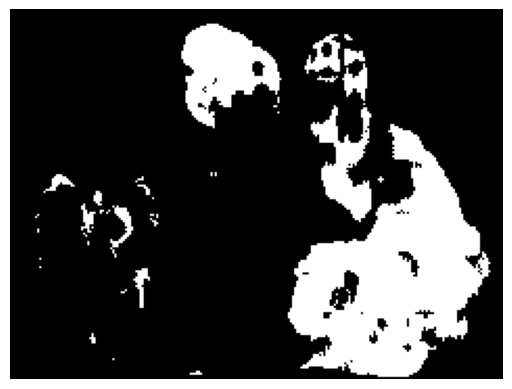

In [60]:
import numpy as np

# Definir el rango de de amarillo que se quedará en la imagen
lower_yellow = np.array([20,50,50])
upper_yellow = np.array([40,255,255])

# Generar una máscara para los valores que satisfacen el rango de color
Imask = cv2.inRange(Ihsv, lower_yellow, upper_yellow)

plt.imshow(Imask, cmap='gray')
plt.axis('off'); plt.show()

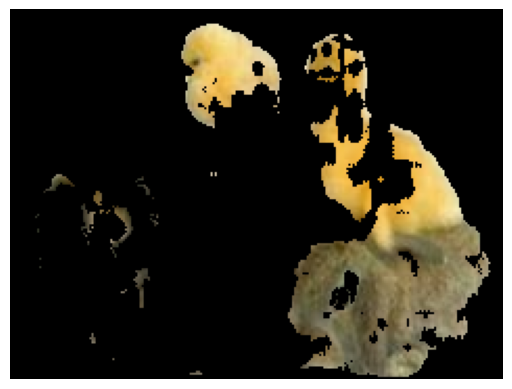

In [61]:
# Aplicar la máscara a la imagen original (mantener los puntos dentro del rango
# de color establecido)
Ifiltcolor = cv2.bitwise_and(I, I, mask=Imask)

plt.imshow(cv2.cvtColor(Ifiltcolor, cv2.COLOR_BGR2RGB))
plt.axis('off'); plt.show()

## 9. Métricas de calidad: MSE y PSNR

In [ ]:
#Mean Squared Error entre dos imágenes (mismo tamaño).
def mse(img1: np.ndarray, img2: np.ndarray) -> float:

    err = np.mean((img1.astype(np.float64) - img2.astype(np.float64)) ** 2)
    return err

#Peak Signal-to-Noise Ratio en decibelios.

def psnr(img1: np.ndarray, img2: np.ndarray, max_val: float = 255.0) -> float:

    err = mse(img1, img2)
    if err == 0:
        return float('inf')
    return 20 * np.log10(max_val / np.sqrt(err))

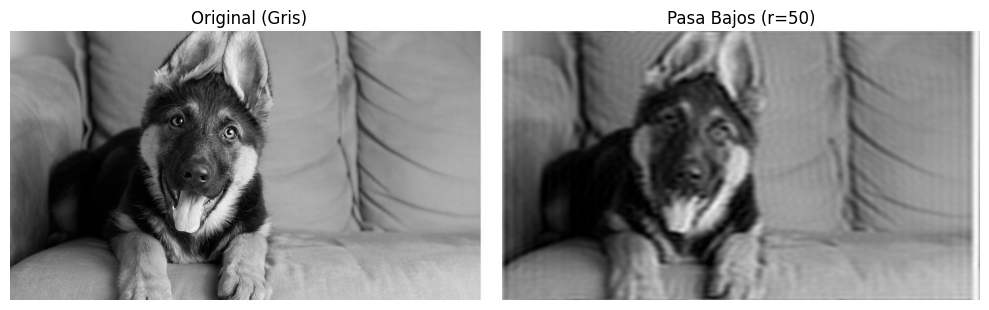

MSE Original vs Pasa Bajos: 222.72
PSNR Original vs Pasa Bajos: 24.65 dB


In [ ]:
# — Ejemplo de uso con pasa bajos —
img_rgb = cargar_imagen('images/perro.png')
gris = convertir_a_gris(img_rgb)

# 2. Filtrado pasa bajos
fshift, _ = calcular_fft(gris)
f_lp = aplicar_filtro_pasa_bajos(fshift, radio=50)
img_lp = reconstruir_imagen(f_lp)

# 3. Mostrar imágenes
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gris, cmap='gray')
plt.title('Original (Gris)')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_lp, cmap='gray')
plt.title('Pasa Bajos (r=50)')
plt.axis('off')

plt.tight_layout()
plt.show()

# 4. Métricas
print(f"MSE Original vs Pasa Bajos: {mse(gris, img_lp):.2f}")
print(f"PSNR Original vs Pasa Bajos: {psnr(gris, img_lp):.2f} dB")

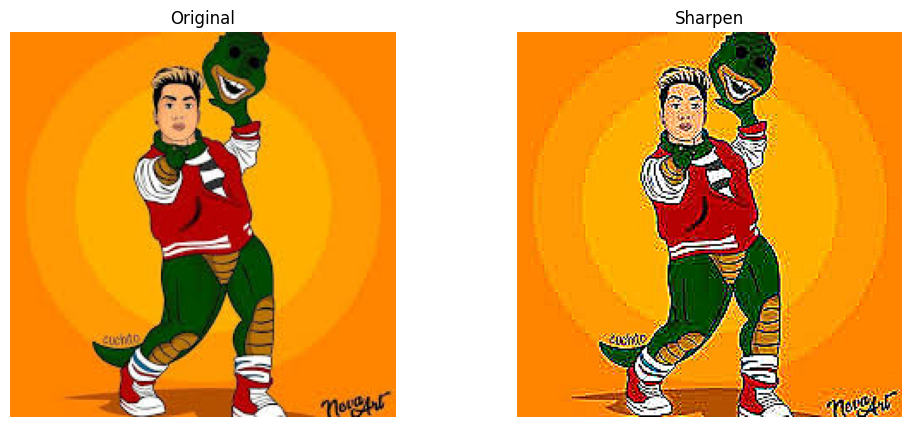

PSNR Original vs Sharpen: 20.63 dB


In [67]:
def filtro_sharpen(img_rgb: np.ndarray) -> np.ndarray:
    kernel = np.array([[0, -1,  0],
                       [-1, 5, -1],
                       [0, -1,  0]], dtype=np.float32)
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    sharpen_bgr = cv2.filter2D(img_bgr, ddepth=-1, kernel=kernel)
    return cv2.cvtColor(sharpen_bgr, cv2.COLOR_BGR2RGB)

# — Ejecución de ejemplo —
img = cargar_imagen('images/sideral.png')
img_sharp = filtro_sharpen(img)

# Mostrar comparación
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img); plt.title('Original'); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img_sharp); plt.title('Sharpen'); plt.axis('off')
plt.show()

print(f"PSNR Original vs Sharpen: {psnr(convertir_a_gris(img), convertir_a_gris(img_sharp)):.2f} dB")
